<a href="https://colab.research.google.com/github/Guo-Weiqiang/Master-Project/blob/main/baseline(EEGNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.autograd import Variable
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
import numpy as np
import torch.optim as optim
import pandas as pd
from torchsummary import summary
import os
import matplotlib.pyplot as plt


# Loss Part




In [16]:
# 1. 成熟的数据集上，与主流的结果比（调整一下架构）
# 2. EEGNet 回归问题
# 3. 联合分布

# *. 可视化 t-sne 看看adapt之后的数据分布
import torch

# def MMD(source, target):
# 	"""
# 	mmd loss(linear)
# 	:param source: torch tensor: source data (Ds) with dimensions DxNs
# 	:param target: torch tensor: target data (Dt) with dimensons DxNt
# 	"""
# 	delta = source - target
# 	loss = torch.mean(torch.mm(delta, torch.transpose(delta, 0, 1)))

# 	return loss


# ref.
# 1. https://github.com/thuml/Xlearn/blob/master/pytorch/src/loss.py
# 2. https://github.com/MaterialsInformaticsDemo/DAN/blob/main/code/MK_MMD.py
# 3. https://github.com/thuml/Transfer-Learning-Library/blob/master/tllib/alignment/dan.py
def gaussian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    # The simplest version: K = \beta * k where \beta=1
    n_samples_source = source.size(0)
    n_samples_target = target.size(0)
    total = torch.cat([source, target], dim=0)

    # Calculate the L2 distance matrix efficiently using matrix operations.
    total_xx = torch.sum(total * total, dim=1, keepdim=True)
    L2_distance = total_xx - 2.0 * torch.matmul(total, total.t()) + total_xx.t()
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        # Set the average value of distance matrix as the bandwidth
        bandwidth = torch.sum(L2_distance.data) / (n_samples_source * n_samples_target - n_samples_source)

    bandwidth /= kernel_mul ** (kernel_num // 2) #
    # bandwidth range [2^{-4}*sigma, 2^4*sigma]
    bandwidth_list = [bandwidth * (kernel_mul ** (2 * i)) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]

    return sum(kernel_val) # final gaussian kernel matrix



def MK_MMD(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = source.size(0)
    # n_t = target.size(0)
    kernels = gaussian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)

    # Efficiently calculate loss components using vectorized operations.
    # SS = torch.triu(kernels[:n_s, :n_s], diagonal=1).sum() / float(n_s * n_s - n_s)
    # TT = torch.triu(kernels[-n_t:, -n_t:], diagonal=1).sum() / float(n_t * n_t - n_t)
    # ST = -kernels[:n_s, -n_t:].sum() / float(n_s * n_t)
    # TS = -kernels[-n_t:, :n_s].sum() / float(n_s * n_t)

    # loss = torch.abs(SS + TT - ST - TS)

    # return loss
    loss1 = torch.triu(kernels[:batch_size, :batch_size], diagonal=1).sum() + torch.triu(kernels[batch_size:, batch_size:], diagonal=1).sum()
    loss1 = loss1 / float(batch_size * (batch_size - 1) / 2)

    loss2 = -kernels[:batch_size, batch_size:].sum() - kernels[batch_size:, :batch_size].sum()
    loss2 = loss2 / float(batch_size * batch_size)

    return loss1 + loss2

def MMD(Xs, Xt):
    ns, nt = Xs.size(0), Xt.size(0)

    # linear version
    mmd_s = (Xs @ Xs.t()).sum() / (ns * (ns - 1))
    mmd_t = (Xt @ Xt.t()).sum() / (nt * (nt - 1))
    mmd_st = (Xs @ Xt.t()).sum() * 2.0 / (ns * nt)
    loss = mmd_s - mmd_st + mmd_t

    return loss

    # single gaussian kenel version
    # return MK_MMD(source, target, kernel_num=1)

# 1. Model Part

In [24]:


# ref.
# 1. https://github.com/agrija9/Deep-Unsupervised-Domain-Adaptation/blob/master/DDC/model.py
class EEGNet_ReLU(torch.nn.Module):
    def __init__(self, n_output):
        super(EEGNet_ReLU, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35)
        )
        self.classify = nn.Sequential(
            nn.Flatten(),
            # nn.Linear(736, 256),
            # nn.ReLU(inplace=True),
            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True),
            # nn.Linear(256, n_output, bias=True)

            # original classifier
            nn.Linear(736, n_output, bias=True)
        )

    def forward(self, x):
        out = self.firstConv(x)
        out = self.depthwiseConv(out)
        out = self.separableConv(out)
        out = self.classify(out)
        return out




class EEGNet_DDC(nn.Module):
    """
    Deep domain confusion network as defined in the paper:
    https://arxiv.org/abs/1412.3474
        :param num_classes: int
    """
    def __init__(self, num_classes):
        super(EEGNet_DDC, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35)
        )

        # Ref. bottleneck in the paper
        # Our intuition is that a lower dimensional layer can be used to regularize the training of the source classiﬁer and prevent overﬁtting to the particular nuances of the source distribution
        self.bottleneck = nn.Sequential(
            nn.Flatten(),
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)
            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(256, num_classes, bias=True)
        )

        # # fc8 activation (final_classifier)
        # # self.fc8 = nn.Linear(736, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Linear(256, num_classes, bias=True)
        # )

    def forward(self, source, target):
        source = self.firstConv(source)
        source = self.depthwiseConv(source)
        source = self.separableConv(source)
        source = self.bottleneck(source)
        # print(source.shape)

        mmd_loss = 0
        if self.training:
            target = self.firstConv(target)
            target = self.depthwiseConv(target)
            target = self.separableConv(target)
            target = self.bottleneck(target)
            # print(target.shape)
            mmd_loss += MMD(source, target)

        result = self.classifier(source)

        return result, mmd_loss


class EEGNet_DAN(nn.Module):
    """
    Deep domain confusion network as defined in the paper:
    https://arxiv.org/abs/1412.3474
        :param num_classes: int
    """
    def __init__(self, num_classes):
        super(EEGNet_DAN, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35)
        )

        # Ref. bottleneck in the paper
        # Our intuition is that a lower dimensional layer can be used to regularize the training of the source classiﬁer and prevent overﬁtting to the particular nuances of the source distribution
        self.bottleneck1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)

            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True)
        )
        self.bottleneck2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(256, num_classes, bias=True)
        )

        # # fc8 activation (final_classifier)
        # # self.fc8 = nn.Linear(736, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Linear(256, num_classes, bias=True)
        # )

    def forward(self, source, target):
        source = self.firstConv(source)
        source = self.depthwiseConv(source)
        source = self.separableConv(source)
        f1_s = self.bottleneck1(source)
        f2_s = self.bottleneck2(f1_s)
        # print(source.shape)

        # if self.training:
        target = self.firstConv(target)
        target = self.depthwiseConv(target)
        target = self.separableConv(target)
        f1_t = self.bottleneck1(target)
        f2_t = self.bottleneck2(f1_t)
        mmd_loss1 = MK_MMD(f1_s, f1_t)
        mmd_loss2 = MK_MMD(f2_s, f2_t)

        result_s = self.classifier(f2_s)
        result_t = self.classifier(f2_t)
        mmd_loss3 = MK_MMD(result_s, result_t) # P(Y)
        mmd_loss = 1 * mmd_loss1 + 1 * mmd_loss2 + 1 * mmd_loss3

        return result_s, mmd_loss


class DeepConvNet_ReLU(torch.nn.Module):
    def __init__(self, n_output):
        super(DeepConvNet_ReLU, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1,5),bias=False),
            nn.Conv2d(25, 25, kernel_size=(2,1),bias=False),
            nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.47),

            nn.Conv2d(25, 50, kernel_size=(1,5),bias=False),
            nn.BatchNorm2d(50, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.47),

            nn.Conv2d(50, 100, kernel_size=(1,5),bias=False),
            nn.BatchNorm2d(100, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.47),

            nn.Conv2d(100, 200, kernel_size=(1,5),bias=False),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.47),

            nn.Flatten(),
            nn.Linear(8600,n_output,bias=True)
        )

    def forward(self, x):
        out = self.model(x)
        return out



# 2. Loss Part

# 3. Evaluation Part

## 3.1 Data Import

In [4]:
import numpy as np


def read_bci_data():
    """
    two subjects: S4b, X11b
    The experiment consists of 3 sessions for each subject. Each session consists of 4 to 9 runs
    """
    S4b_train = np.load('drive/MyDrive/EEGNet/S4b_train.npz')
    X11b_train = np.load('drive/MyDrive/EEGNet/X11b_train.npz')
    S4b_test = np.load('drive/MyDrive/EEGNet/S4b_test.npz')
    X11b_test = np.load('drive/MyDrive/EEGNet/X11b_test.npz')

    source_data = S4b_train['signal']
    source_label = S4b_train['label']
    val_data = S4b_test['signal']
    val_label = S4b_test['label']
    # target_data = X11b_train['signal']
    # target_label = X11b_train['label']
    # source_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    # source_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    # target_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    # target_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    # source_data = np.concatenate((S4b_train['signal'], S4b_test['signal']), axis=0)
    # source_label = np.concatenate((S4b_train['label'], S4b_test['label']), axis=0)
    target_data = np.concatenate((X11b_train['signal'], X11b_test['signal']), axis=0)
    target_label = np.concatenate((X11b_train['label'], X11b_test['label']), axis=0)

    source_label = source_label - 1
    val_label = val_label - 1
    target_label = target_label - 1
    source_data = np.transpose(np.expand_dims(source_data, axis=1), (0, 1, 3, 2))
    val_data = np.transpose(np.expand_dims(val_data, axis=1), (0, 1, 3, 2))
    target_data = np.transpose(np.expand_dims(target_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(source_data))
    source_data[mask] = np.nanmean(source_data)

    mask = np.where(np.isnan(val_data))
    val_data[mask] = np.nanmean(val_data)

    mask = np.where(np.isnan(target_data))
    target_data[mask] = np.nanmean(target_data)

    # val_data = np.concatenate((source_data[-360:], target_data[-360:]), axis=0)
    # val_label = np.concatenate((source_label[-360:], target_label[-360:]), axis=0)
    # val_data = source_data[-540:]
    # val_label = source_label[-540:]
    # source_data = source_data[0:-540]
    # source_label = source_label[0:-540]
    # target_data = target_data[0:-360]
    # target_label = target_label[0:-360]

    print(source_data.shape, source_label.shape, val_data.shape, val_label.shape, target_data.shape, target_label.shape)

    return source_data, source_label, val_data, val_label, target_data, target_label


source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()


(540, 1, 2, 750) (540,) (540, 1, 2, 750) (540,) (1080, 1, 2, 750) (1080,)


## 3.2 without DA

(540, 1, 2, 750) (540,) (540, 1, 2, 750) (540,) (1080, 1, 2, 750) (1080,)
EEGNet_ReLU(
  (firstConv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=8, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.35, inplace=False)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.35, inplace=False)
  )
  (classify): Sequential(
    (0): Flatten(sta

<ipython-input-64-67bf97175732>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


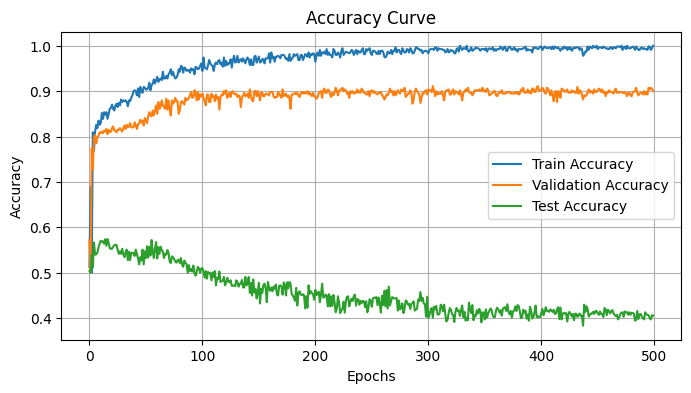

In [64]:

def test(x_test,y_test,model,device):

    # model.load_state_dict(torch.load(filepath))
    model.eval()
    with torch.no_grad():
        model.cuda(0)
        n = x_test.shape[0]

        x_test = x_test.astype("float32")
        y_test = y_test.astype("float32").reshape(y_test.shape[0],)

        x_test, y_test = Variable(torch.from_numpy(x_test)),Variable(torch.from_numpy(y_test))

        x_test,y_test = x_test.to(device),y_test.to(device)
        y_pred_test = model(x_test)

        correct_test = (torch.max(y_pred_test,1)[1]==y_test).sum().item()
        test_accuracy = correct_test/n
        # print("testing accuracy:",correct/n)

    return test_accuracy


def train(source_data, source_label, val_data, val_label, target_data, target_label, epochs=500, lr=1e-3):
    torch.manual_seed(1)    # reproducible

    max_training_accuracy = 0
    max_test_accuracy = 0
    device = torch.device("cuda:0")

    source_data = source_data.astype("float32")
    source_label = source_label.astype("float32").reshape(source_label.shape[0],)


    x, y = Variable(torch.from_numpy(source_data)), Variable(torch.from_numpy(source_label))
    y = torch.tensor(y, dtype=torch.long)

    # target_data, target_label = Variable(torch.from_numpy(target_data)), Variable(torch.from_numpy(target_label))
    # target_label = torch.tensor(target_label, dtype=torch.long)

    model = EEGNet_ReLU(n_output=2)
    print(model)
    criterion = nn.CrossEntropyLoss()

    # optimizer = optim.Adam(model.parameters(),lr = lr)
    optimizer = optim.RMSprop(model.parameters(),lr = lr, momentum = 0.2)
    # optimizer = optim.SGD(model.parameters(), lr=1, momentum=0.5, weight_decay=5e-4)

    # model.cuda(0)
    summary(model.cuda(),(1,2,750))

    loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(epochs):
        model.train()
        x, y = x.to(device), y.to(device)
        y_pred = model(x)

        loss = criterion(y_pred, y)
        loss_history.append(loss.item())


        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        sample_cnt = y.shape[0]
        correct = (torch.max(y_pred,1)[1]==y).sum().item()
        train_accuracy = correct / sample_cnt
        train_accuracy_history.append(train_accuracy)

        val_accuracy = test(val_data, val_label, model, device)
        val_accuracy_history.append(val_accuracy)

        test_accuracy = test(target_data, target_label, model, device)
        test_accuracy_history.append(test_accuracy)

        # print("epochs:",epoch,"loss:",loss.item(),"D_s Accuracy:",train_accuracy,"validation accuracy: ", val_accuracy, "D_t Accuracy:",test_accuracy)

        max_training_accuracy = max(train_accuracy, max_training_accuracy)

        max_test_accuracy = max(test_accuracy, max_test_accuracy)

    plt.figure(figsize=(8, 4))
    # plt.plot(loss_history, label="Loss")
    plt.plot(train_accuracy_history, label='Train Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    plt.plot(test_accuracy_history, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.grid(True)
    plt.show()



source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
train(source_data, source_label, val_data, val_label, target_data, target_label, epochs=500, lr=1e-3)

## 3.3 With DA

In [20]:
def test(data, label, model, device):
    model.eval()

    data, label = data.to(device), label.to(device)
    pred, _ = model(data, data)

    correct_cnt = (torch.max(pred, 1)[1]== label).sum().item()
    sample_cnt = data.shape[0]
    accuracy = correct_cnt / sample_cnt

    return accuracy

def train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=0.5, epochs=500, lr=1e-3):
    torch.manual_seed(1)    # reproducible

    min_loss = 1
    max_training_accuracy = 0
    max_test_accuracy = 0
    device = torch.device("cuda:0")

    source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()

    source_data = source_data.astype("float32")
    source_label = source_label.astype("float32").reshape(source_label.shape[0],)

    target_data = target_data.astype("float32")
    target_label = target_label.astype("float32").reshape(target_label.shape[0],)

    val_data = val_data.astype("float32")
    val_label = val_label.astype("float32").reshape(val_label.shape[0],)

    source_data, source_label = torch.from_numpy(source_data), torch.from_numpy(source_label)
    source_label = torch.tensor(source_label, dtype=torch.long)
    target_data, target_label = torch.from_numpy(target_data), torch.from_numpy(target_label)
    target_label = torch.tensor(target_label, dtype=torch.long)
    val_data, val_label = torch.from_numpy(val_data), torch.from_numpy(val_label)
    val_label = torch.tensor(val_label, dtype=torch.long)


    # print(model)
    summary(model.cuda(), [(1, 2, 750), (1, 2, 750)])


    # optimizer = optim.Adam(model.parameters(),lr = lr)
    # optimizer = optim.RMSprop(model.parameters(),lr = lr, momentum = 0.2)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=5e-4)

    model.cuda(0)

    clf_loss_history = []
    mmd_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    test_accuracy_history = []


    for epoch in range(epochs):
        model.train()

        source_data, source_label = source_data.to(device), source_label.to(device)
        target_data = target_data.to(device)

        preds, mmd_loss = model(source_data, target_data)

        # compute losses (classification and coral loss)
        clf_loss = torch.nn.functional.cross_entropy(preds, source_label)

        # compute total loss (equation 2 in the paper paper)
        loss = clf_loss + lambda_factor * mmd_loss

        clf_loss_history.append(loss.item())
        mmd_loss_history.append(mmd_loss.item())

        correct_cnt = (torch.max(preds, 1)[1]== source_label).sum().item()
        accuracy = correct_cnt / source_data.shape[0]
        train_accuracy_history.append(accuracy)

        # compute gradients of network (backprop in pytorch)
        loss.backward()

        # update weights of network
        optimizer.step()

        # reset optimizer gradients to zero
        optimizer.zero_grad()

        val_accuracy = test(val_data, val_label, model,device)
        val_accuracy_history.append(val_accuracy)

        test_accuracy = test(target_data, target_label, model, device)
        test_accuracy_history.append(test_accuracy)

        # print("epochs:", epoch, "classification loss:", clf_loss.item(), "MMD loss", mmd_loss.item(),
        #         "D_s accuracy:", accuracy, "val accuracy:", val_accuracy, "D_t accuracy:", test_accuracy)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    # plt.plot(loss_history, label="Loss")
    plt.plot(train_accuracy_history, label='Train Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    plt.plot(test_accuracy_history, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.grid(True)
    # plt.show()


    plt.subplot(1, 2, 2)
    plt.plot(clf_loss_history, label="CLF Loss")
    plt.plot(mmd_loss_history, label='MMD Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.grid(True)
    plt.show()



## DDC

(540, 1, 2, 750) (540,) (540, 1, 2, 750) (540,) (1080, 1, 2, 750) (1080,)
(540, 1, 2, 750) (540,) (540, 1, 2, 750) (540,) (1080, 1, 2, 750) (1080,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 2, 750]             816
       BatchNorm2d-2           [-1, 16, 2, 750]              32
            Conv2d-3           [-1, 32, 1, 750]             128
       BatchNorm2d-4           [-1, 32, 1, 750]              64
              ReLU-5           [-1, 32, 1, 750]               0
         AvgPool2d-6           [-1, 32, 1, 187]               0
           Dropout-7           [-1, 32, 1, 187]               0
            Conv2d-8           [-1, 32, 1, 187]          15,360
       BatchNorm2d-9           [-1, 32, 1, 187]              64
             ReLU-10           [-1, 32, 1, 187]               0
        AvgPool2d-11            [-1, 32, 1, 23]               0
          Dropout-1

<ipython-input-20-c836f6e4934e>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source_label = torch.tensor(source_label, dtype=torch.long)
<ipython-input-20-c836f6e4934e>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_label = torch.tensor(target_label, dtype=torch.long)
<ipython-input-20-c836f6e4934e>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_label = torch.tensor(val_label, dtype=torch.long)


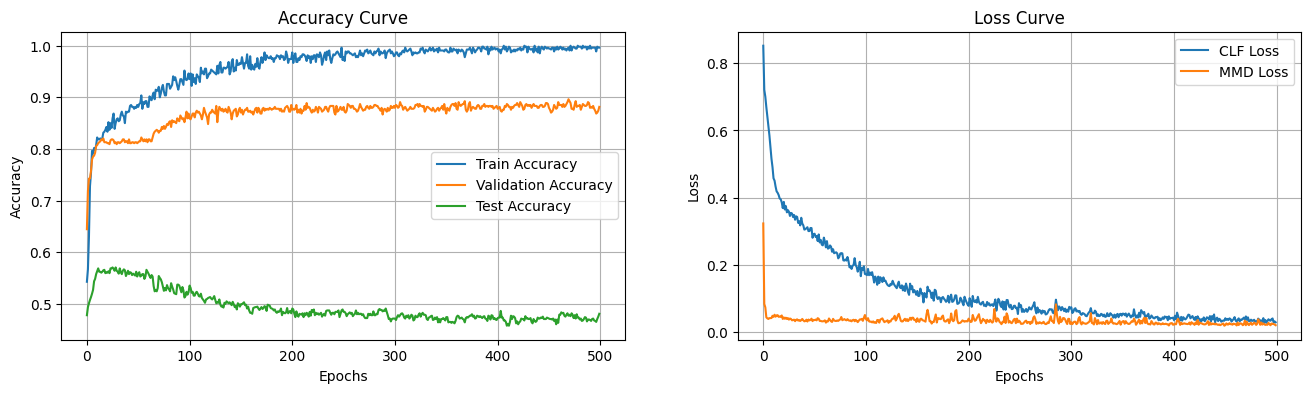

In [21]:
model = EEGNet_DDC(num_classes=2)
source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=0.5, epochs=500, lr=1e-1)

## with DA (DAN)

(540, 1, 2, 750) (540,) (540, 1, 2, 750) (540,) (1080, 1, 2, 750) (1080,)
(540, 1, 2, 750) (540,) (540, 1, 2, 750) (540,) (1080, 1, 2, 750) (1080,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 2, 750]             816
       BatchNorm2d-2           [-1, 16, 2, 750]              32
            Conv2d-3           [-1, 32, 1, 750]             128
       BatchNorm2d-4           [-1, 32, 1, 750]              64
              ReLU-5           [-1, 32, 1, 750]               0
         AvgPool2d-6           [-1, 32, 1, 187]               0
           Dropout-7           [-1, 32, 1, 187]               0
            Conv2d-8           [-1, 32, 1, 187]          15,360
       BatchNorm2d-9           [-1, 32, 1, 187]              64
             ReLU-10           [-1, 32, 1, 187]               0
        AvgPool2d-11            [-1, 32, 1, 23]               0
          Dropout-1

<ipython-input-20-c836f6e4934e>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source_label = torch.tensor(source_label, dtype=torch.long)
<ipython-input-20-c836f6e4934e>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_label = torch.tensor(target_label, dtype=torch.long)
<ipython-input-20-c836f6e4934e>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_label = torch.tensor(val_label, dtype=torch.long)


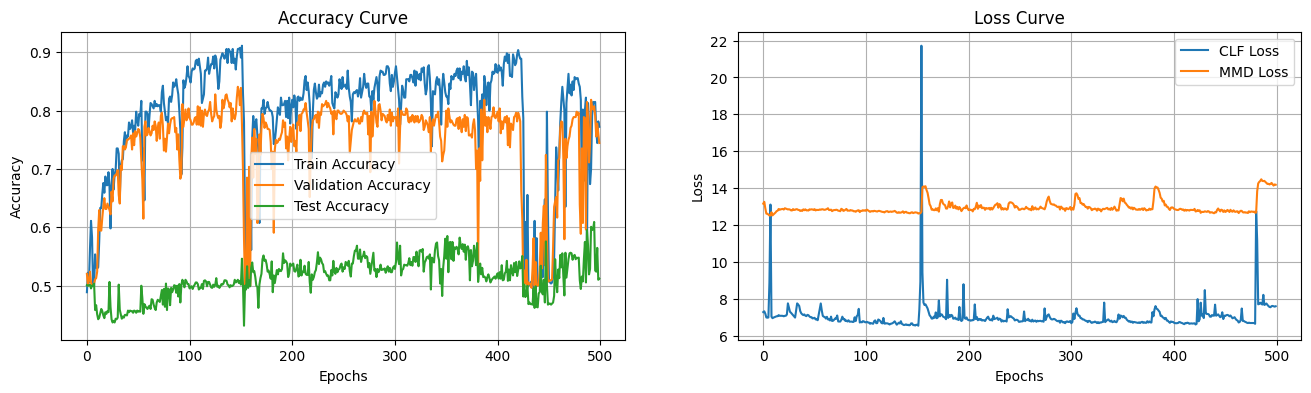

In [25]:
model = EEGNet_DAN(num_classes=2)
source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=0.5, epochs=500, lr=1e-1)
# 发现：加入MK-MMD(gaussian kernels)收敛会变困难

## TCA

In [31]:
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K


class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = K @ M @ K.T + self.lamb * np.eye(n_eye), K @ H @ K.T
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = A.T @ K
        Z /= np.linalg.norm(Z, axis=0)

        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)

        return acc, y_pred

    # TCA code is done here. You can ignore fit_new and fit_predict_new.

    def fit_new(self, Xs, Xt, Xt2):
        '''
        Map Xt2 to the latent space created from Xt and Xs
        :param Xs : ns * n_feature, source feature
        :param Xt : nt * n_feature, target feature
        :param Xt2: n_s, n_feature, target feature to be mapped
        :return: Xt2_new, mapped Xt2 with projection created by Xs and Xt
        '''
        # Computing projection matrix A from Xs an Xt
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot(
            [K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]

        # Compute kernel with Xt2 as target and X as source
        Xt2 = Xt2.T
        K = kernel(self.kernel_type, X1=Xt2, X2=X, gamma=self.gamma)

        # New target features
        Xt2_new = K @ A

        return Xt2_new

    def fit_predict_new(self, Xt, Xs, Ys, Xt2, Yt2):
        '''
        Transfrom Xt and Xs, get Xs_new
        Transform Xt2 with projection matrix created by Xs and Xt, get Xt2_new
        Make predictions on Xt2_new using classifier trained on Xs_new
        :param Xt: ns * n_feature, target feature
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt2: nt * n_feature, new target feature
        :param Yt2: nt * 1, new target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, _ = self.fit(Xs, Xt)
        Xt2_new = self.fit_new(Xs, Xt, Xt2)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt2_new)
        acc = sklearn.metrics.accuracy_score(Yt2, y_pred)

        return acc, y_pred


def train_valid():
    # If you want to perform train-valid-test, you can use this function
    domains = ['caltech.mat', 'amazon.mat', 'webcam.mat', 'dslr.mat']
    for i in [1]:
        for j in [2]:
            if i != j:
                src, tar = 'data/' + domains[i], 'data/' + domains[j]
                src_domain, tar_domain = scipy.io.loadmat(
                    src), scipy.io.loadmat(tar)
                Xs, Ys, Xt, Yt = src_domain['feas'], src_domain['label'], tar_domain['feas'], tar_domain['label']

                # Split target data
                Xt1, Xt2, Yt1, Yt2 = train_test_split(
                    Xt, Yt, train_size=50, stratify=Yt, random_state=42)

                # Create latent space and evaluate using Xs and Xt1
                tca = TCA(kernel_type='linear', dim=30, lamb=1, gamma=1)
                acc1, ypre1 = tca.fit_predict(Xs, Ys, Xt1, Yt1)

                # Project and evaluate Xt2 existing projection matrix and classifier
                acc2, ypre2 = tca.fit_predict_new(Xt1, Xs, Ys, Xt2, Yt2)

    print(f'Accuracy of mapped source and target1 data : {acc1:.3f}')  # 0.800
    print(f'Accuracy of mapped target2 data            : {acc2:.3f}')  # 0.706




In [33]:
S4b_train = np.load('drive/MyDrive/EEGNet/S4b_train.npz')
X11b_train = np.load('drive/MyDrive/EEGNet/X11b_train.npz')
S4b_test = np.load('drive/MyDrive/EEGNet/S4b_test.npz')
X11b_test = np.load('drive/MyDrive/EEGNet/X11b_test.npz')

source_data = S4b_train['signal']
source_label = S4b_train['label']
val_data = S4b_test['signal']
val_label = S4b_test['label']
target_data = np.concatenate((X11b_train['signal'], X11b_test['signal']), axis=0)
target_label = np.concatenate((X11b_train['label'], X11b_test['label']), axis=0)

print(source_data.shape)
print(source_label.shape)
print(target_data.shape)
print(target_label.shape)

source_data = source_data.reshape(source_data.shape[0], -1)
target_data = target_data.reshape(target_data.shape[0], -1)

print(source_data.shape)
print(target_data.shape)

mask = np.where(np.isnan(source_data))
source_data[mask] = np.nanmean(source_data)

mask = np.where(np.isnan(target_data))
target_data[mask] = np.nanmean(target_data)

(540, 750, 2)
(540,)
(1080, 750, 2)
(1080,)
(540, 1500)
(1080, 1500)


In [34]:
tca = TCA(kernel_type='linear', dim=30, lamb=1, gamma=1)
acc, ypred = tca.fit_predict(source_data, source_label, target_data, target_label)
print(f'Accuracy: {acc:.3f}')

Accuracy: 0.504


## DaNN